In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os
import gc
import umap
import umap.plot
import joblib
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from sklearn.preprocessing import LabelEncoder

In [2]:
RANDOM_SEED = 2121
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
df = pd.read_csv("../input/sharktank-data/sharktankfull.csv", index_col = 0)

In [5]:
df = df.drop(508, axis=0)

In [6]:
for i, c, in enumerate(df.Category.unique()):
    print(f"id: {i}, name: '{c}'")

id: 0, name: 'Health / Wellness'
id: 1, name: 'Food and Beverage'
id: 2, name: 'Business Services'
id: 3, name: 'Lifestyle / Home'
id: 4, name: 'Software / Tech'
id: 5, name: 'Children / Education'
id: 6, name: 'Automotive'
id: 7, name: 'Fashion / Beauty'
id: 8, name: 'Media / Entertainment'
id: 9, name: 'Fitness / Sports / Outdoors'
id: 10, name: 'Pet Products'
id: 11, name: 'Green/CleanTech'
id: 12, name: 'Travel'
id: 13, name: 'Uncertain / Other'


In [7]:
df['DealAmount']

0       50000.0
1      460000.0
2           NaN
3           NaN
4           NaN
         ...   
890    350000.0
891    250000.0
892    500000.0
893    100000.0
894         NaN
Name: DealAmount, Length: 894, dtype: float64

In [8]:
X = df[['GotDeal',
        'Category',
        'AskAmount',
        'AskEquity',
        'AskValuation',
        'State',
        'City',
        'EntrepreneurGender',
       ]]

In [9]:
X.columns = ['deal',
            'category',
            'ask',
            'equity',
            'valuation',
            'state',
            'city',
            'gender']

In [10]:
X.head()

,deal,category,ask,equity,valuation,state,city,gender
0,1,Health / Wellness,50000.0,15.0,333333.0,GA,Atlanta,Female
1,1,Food and Beverage,460000.0,10.0,4600000.0,NJ,Somerset,Male
2,0,Business Services,1200000.0,10.0,12000000.0,NC,Cary,Male
3,0,Lifestyle / Home,250000.0,25.0,1000000.0,FL,Tampa,Male
4,0,Software / Tech,1000000.0,15.0,6666667.0,MN,St. Paul,Male


In [11]:
numeric_cols = ['ask', 'equity', 'valuation']

In [12]:
# X['deal'] = X.deal.apply(int)
# X['city'] = X['location'].str.split(",").apply(lambda x: x[0])
# X['state'] = X['location'].str.split(",").apply(lambda x: x[1])
# X['website'] = X['website'].apply(lambda x: 1 if x is not None else 0)
# X['multiple'] = X.multiple.apply(int)

encoder = LabelEncoder()
X['category'] = encoder.fit_transform(X['category'])
encoder = LabelEncoder()
X['city'] = encoder.fit_transform(X['city'])
encoder = LabelEncoder()
X['state'] = encoder.fit_transform(X['state'])
encoder = LabelEncoder()
X['gender'] = encoder.fit_transform(X['gender'])

#didn't feel like adding a scaler because the embedding should learn the whole distribution
X['valuation'] = X.valuation / 100000 #val in 100ks
X['ask'] = X.ask / 10000 #ask in 10ks

In [13]:
y = X.pop('deal')

In [14]:
catcols = ['category', 'state', 'city', 'gender']

In [15]:
y = pd.get_dummies(y)

In [16]:
def create_model(data, catcols):
    # numeric features being fed into the model:
    numeric = layers.Input(shape=(len(numeric_cols),), name = 'numeric')
    n = layers.BatchNormalization()(numeric)
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = 3 #int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
#     x = layers.DenseFeatures(feature_columns)
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    #n = layers.Dense(3, activation = 'swish')(n)
    x = layers.Concatenate()([x,n])
    x = layers.Dense(8, activation="relu", name = 'feature_vector')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)
    inputs.append(numeric)
    model = Model(inputs=[inputs], outputs=y)
    return model

In [17]:
model = create_model(X, catcols)

2022-12-16 14:09:26.332197: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', 'AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [19]:
X[X[numeric_cols].isna().any(axis=1)]

,category,ask,equity,valuation,state,city,gender


In [20]:
# X = X.drop(508, axis=0)

In [21]:
# y = y.drop(508, axis=0)

In [22]:
X[X[numeric_cols].isna().any(axis=1)]

,category,ask,equity,valuation,state,city,gender


In [23]:
categorical = [X[col] for col in X[catcols]]
numerical = [X[numeric_cols].to_numpy()]
inputs = categorical + numerical

In [24]:
inputs

[0       7
 1       5
 2       1
 3       8
 4      11
        ..
 890     8
 891     5
 892     3
 893     8
 894    10
 Name: category, Length: 894, dtype: int64,
 0      11
 1      30
 2      27
 3      10
 4      23
        ..
 890    46
 891    46
 892     4
 893    46
 894    46
 Name: state, Length: 894, dtype: int64,
 0        7
 1      214
 2       33
 3      224
 4      220
       ... 
 890    249
 891    249
 892    249
 893    249
 894    249
 Name: city, Length: 894, dtype: int64,
 0      0
 1      1
 2      1
 3      1
 4      1
       ..
 890    1
 891    1
 892    1
 893    1
 894    2
 Name: gender, Length: 894, dtype: int64,
 array([[  5.     ,  15.     ,   3.33333],
        [ 46.     ,  10.     ,  46.     ],
        [120.     ,  10.     , 120.     ],
        ...,
        [ 50.     ,   5.     , 100.     ],
        [ 10.     ,  16.     ,   6.25   ],
        [ 25.     ,  10.     ,  25.     ]])]

In [25]:
X[catcols].isna().values.any()

False

In [26]:
tf.config.run_functions_eagerly(True)

In [27]:
es = callbacks.EarlyStopping(monitor ='val_loss', patience = 5, restore_best_weights = True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [28]:
model.fit(x = inputs, y = y, epochs = 30, callbacks = [es, rlr], validation_split = 0.2)

2022-12-16 14:09:28.628091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
23/23 [==============================] - 1s 52ms/step - loss: 0.9561 - accuracy: 0.5049 - auc: 0.4820 - val_loss: 0.7465 - val_accuracy: 0.5866 - val_auc: 0.5967
Epoch 2/30
23/23 [==============================] - 1s 50ms/step - loss: 0.8724 - accuracy: 0.5133 - auc: 0.5252 - val_loss: 0.7197 - val_accuracy: 0.6089 - val_auc: 0.5906
Epoch 3/30
23/23 [==============================] - 1s 50ms/step - loss: 0.8148 - accuracy: 0.5301 - auc: 0.5429 - val_loss: 0.7071 - val_accuracy: 0.5978 - val_auc: 0.5924
Epoch 4/30
23/23 [==============================] - 1s 51ms/step - loss: 0.8003 - accuracy: 0.5259 - auc: 0.5453 - val_loss: 0.6987 - val_accuracy: 0.6145 - val_auc: 0.6054
Epoch 5/30
23/23 [==============================] - 1s 52ms/step - loss: 0.7456 - accuracy: 0.5524 - auc: 0.5885 - val_loss: 0.6811 - val_accuracy: 0.6201 - val_auc: 0.6494
Epoch 6/30
23/23 [==============================] - 1s 51ms/step - loss: 0.7336 - accuracy: 0.5664 - auc: 0.5929 - val_loss: 0.6709 - v

In [29]:
K.set_value(model.optimizer.learning_rate, 0.0001)
model.fit(x = inputs, y = y, epochs = 1, callbacks = [es, rlr])

28/28 [==============================] - 1s 43ms/step - loss: 0.6248 - accuracy: 0.6812 - auc: 0.7146


In [30]:
city_embedding = model.get_layer('city')
state_embedding = model.get_layer('state')
gender_embedding = model.get_layer('gender')
cat_embedding = model.get_layer('category')

In [31]:
feature_vector = Model(model.input, model.get_layer('feature_vector').output)

In [32]:
city_embedding(tf.constant(X['city'].iloc[0]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.03200014, 0.01055181, 0.02747245], dtype=float32)>

In [33]:
city_embeddings = city_embedding(tf.constant(X['city']))
state_embeddings = state_embedding(tf.constant(X['state']))
gender_embeddings = gender_embedding(tf.constant(X['gender']))
cat_embeddings = cat_embedding(tf.constant(X['category']))
feature_embeddings = feature_vector.predict(inputs)

In [34]:
city_embeddings

<tf.Tensor: shape=(894, 3), dtype=float32, numpy=
array([[ 0.03200014,  0.01055181,  0.02747245],
       [ 0.0195612 ,  0.03520909,  0.02990276],
       [-0.03848928, -0.03655094,  0.00763437],
       ...,
       [ 0.01304476,  0.0107699 ,  0.01387349],
       [ 0.01304476,  0.0107699 ,  0.01387349],
       [ 0.01304476,  0.0107699 ,  0.01387349]], dtype=float32)>

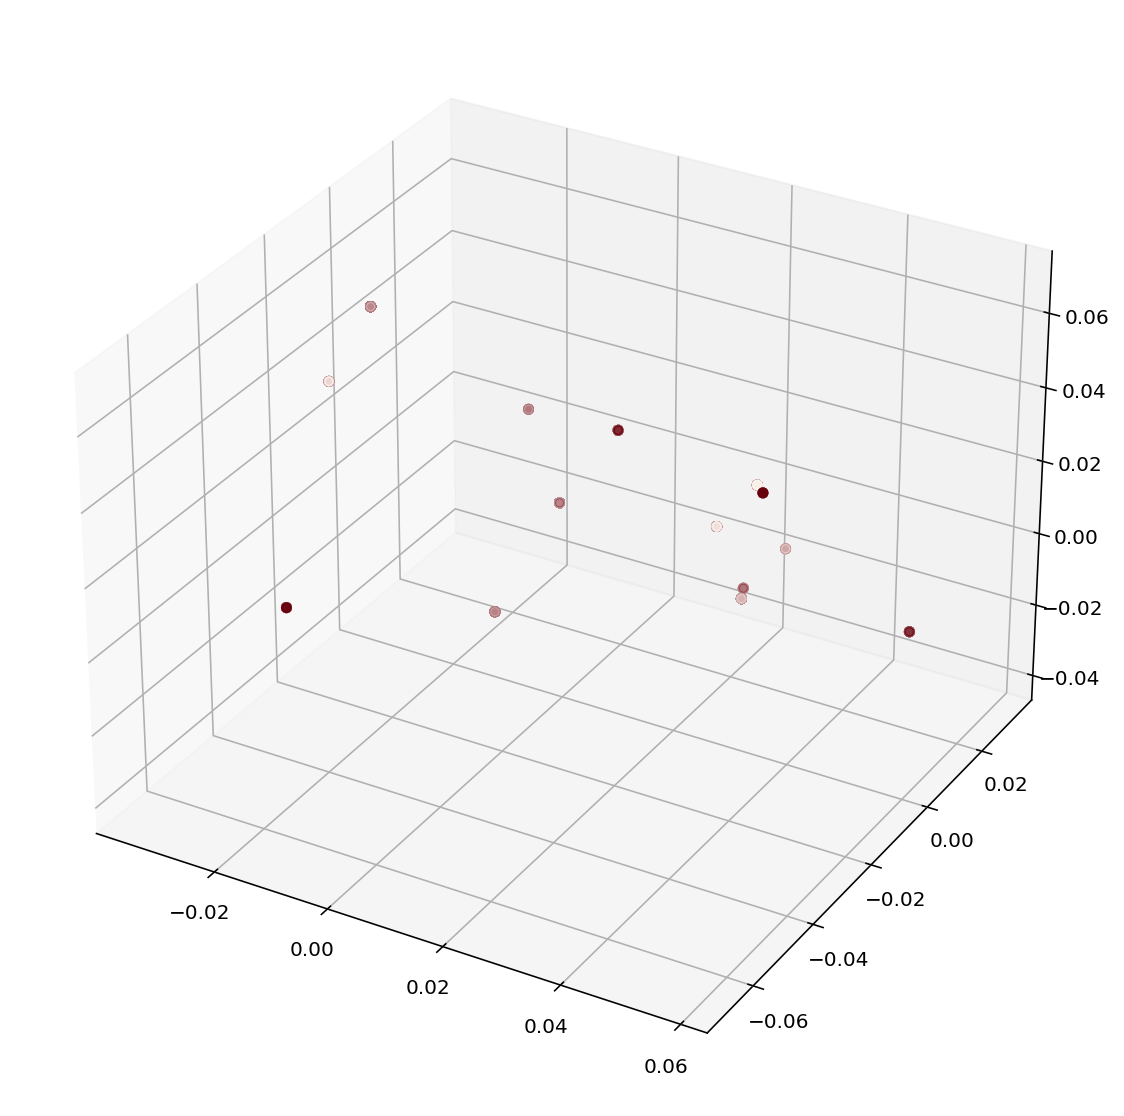

In [35]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = cat_embeddings.numpy()[:, 0], cat_embeddings.numpy()[:, 1], cat_embeddings.numpy()[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
plt.show()

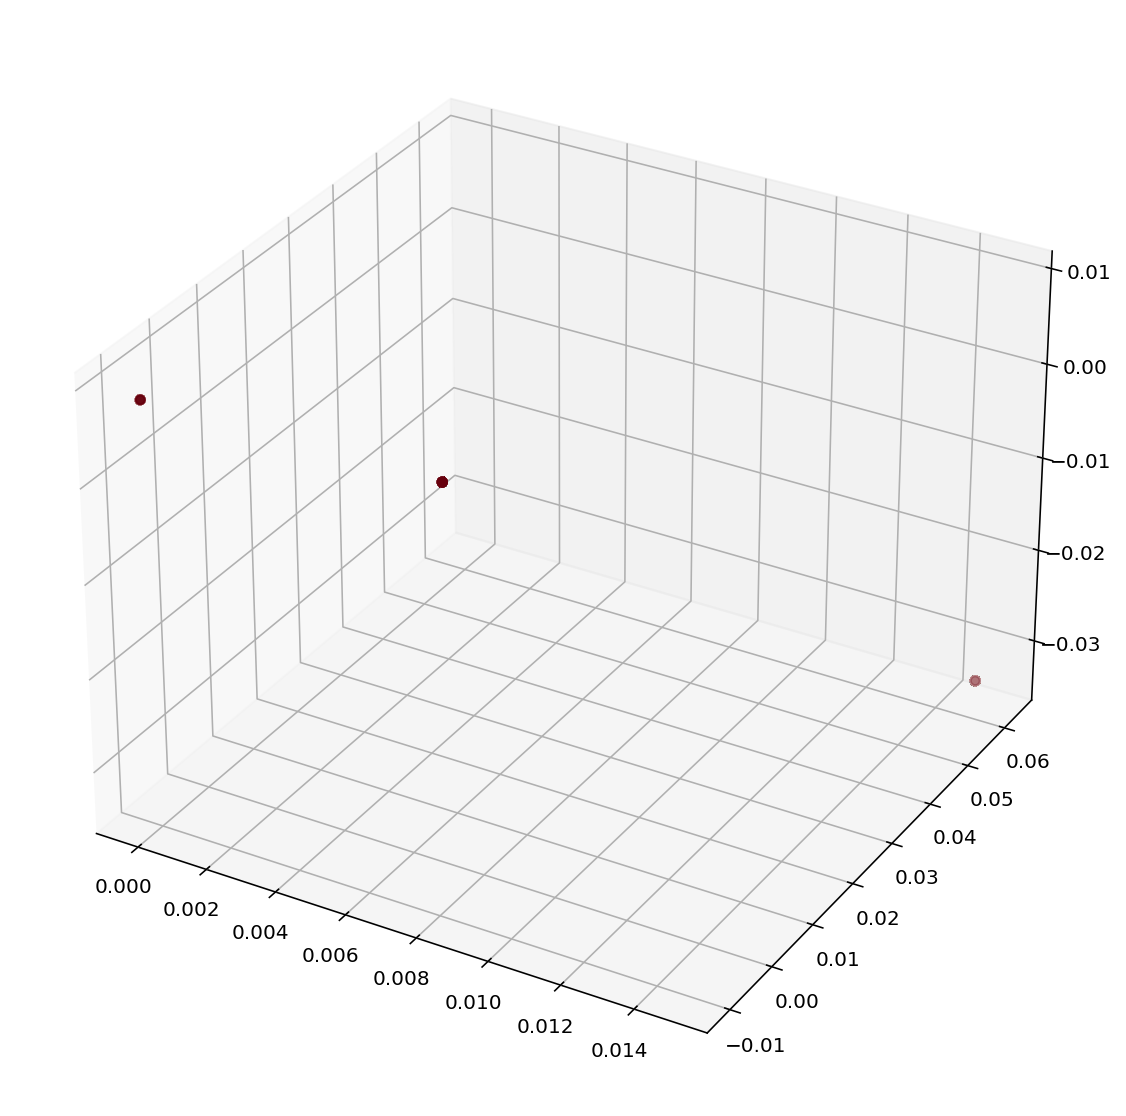

In [36]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = gender_embeddings.numpy()[:, 0], gender_embeddings.numpy()[:, 1], gender_embeddings.numpy()[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
plt.show()

In [37]:
df['EntrepreneurGender'].unique()

array(['Female', 'Male', 'Mixed Team'], dtype=object)

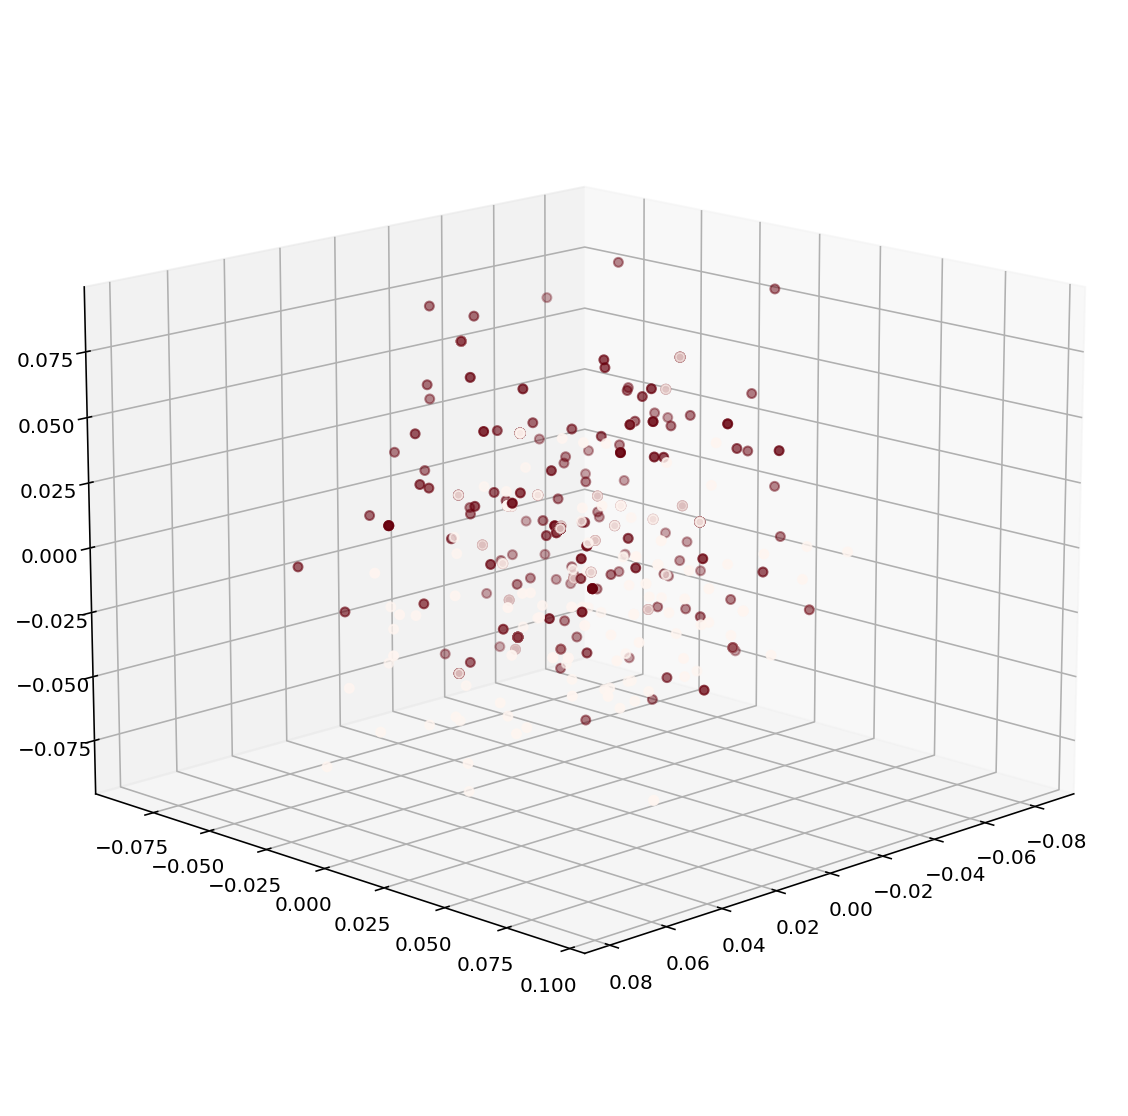

In [38]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = city_embeddings.numpy()[:, 0], city_embeddings.numpy()[:, 1], city_embeddings.numpy()[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
ax.view_init(15,45)
plt.show()

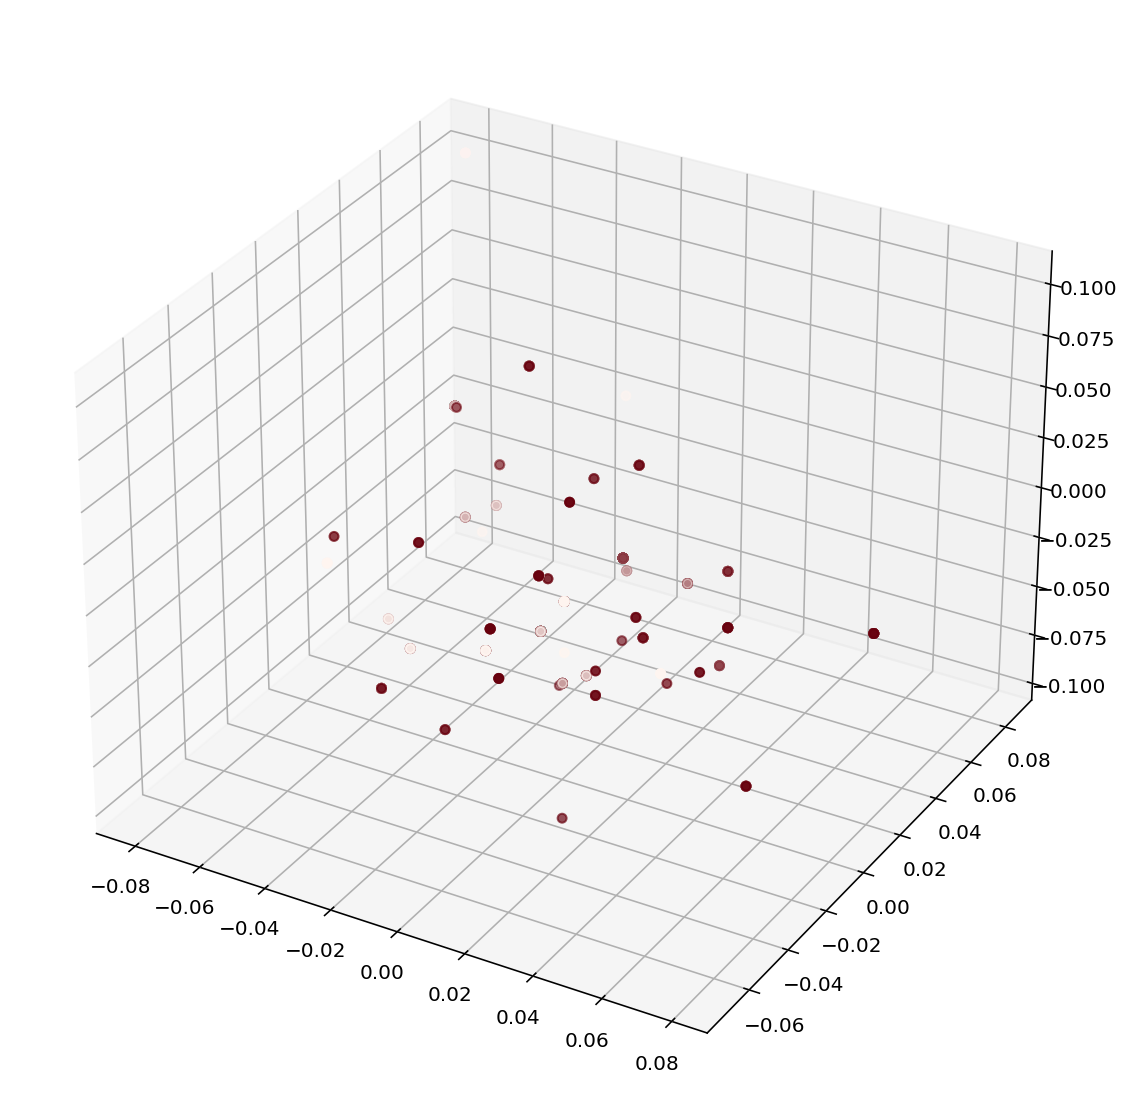

In [39]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = state_embeddings.numpy()[:, 0], state_embeddings.numpy()[:, 1], state_embeddings.numpy()[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
plt.show()

In [40]:
mapper = umap.UMAP(n_components = 3, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings)
umap_features = mapper.transform(feature_embeddings)
pd.DataFrame(umap_features).to_csv("uma13.csv", index = False)

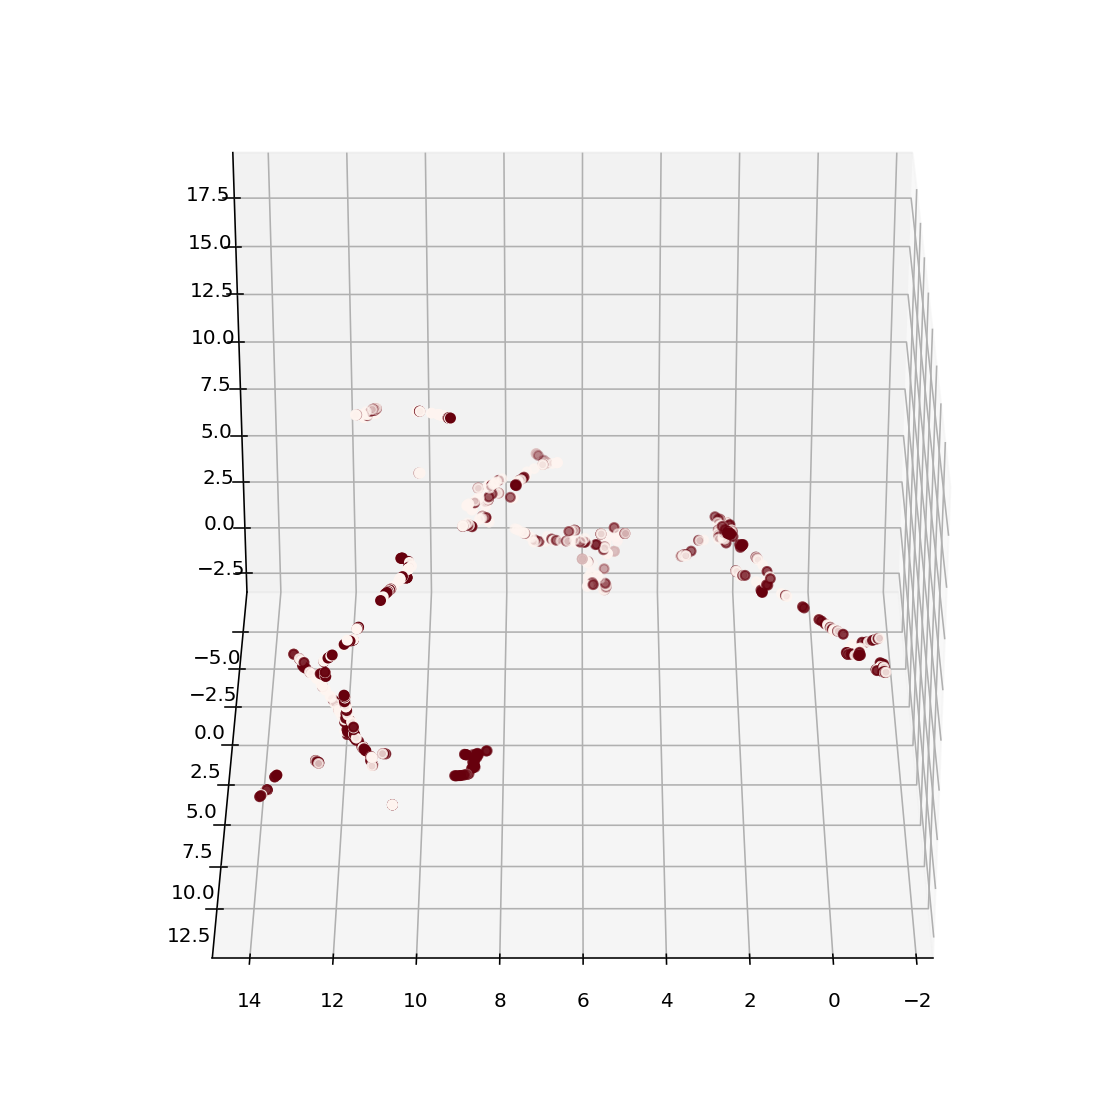

In [41]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = umap_features[:, 0], umap_features[:, 1], umap_features[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
# rotate the axes and update
ax.view_init(30,90)
plt.show()

<AxesSubplot:>

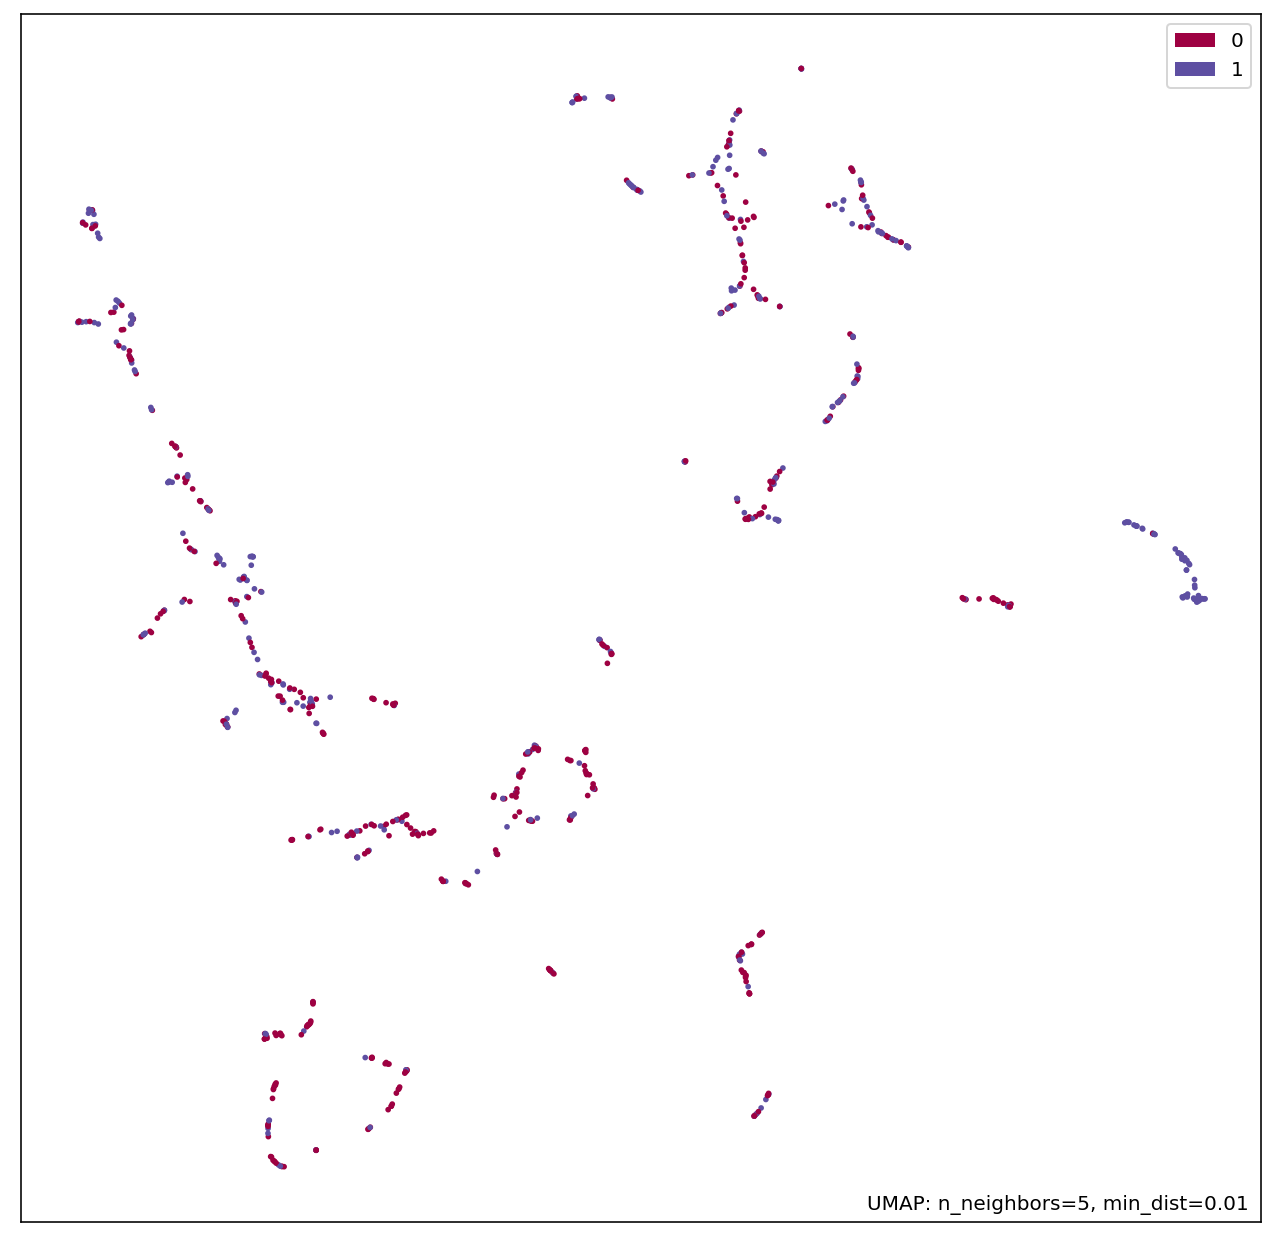

In [42]:
mapper2d = umap.UMAP(n_components = 2, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings)
umap_features2d = mapper2d.transform(feature_embeddings)
umap.plot.points(mapper2d, labels=y.iloc[:, 0])

In [43]:
df

,SeasonEpisode,Season,Episode,Category,CategorySTC,TitleHT,TitleSTC,GotDeal,NoDeal,EntrepreneurGender,...,EntrepreneurNames,MultipleEntrepreneurs,KevinHarringtonPresent,DaymondJohnPresent,KevinOLearyPresent,BarbaraCorcoranPresent,RobertHerjavecPresent,LoriGreinerPresent,MarkCubanPresent,Guest
0,1-1,1,1,Health / Wellness,Baby and Child Care,Ava the Elephant,Ava the Elephant,1,0,Female,...,Tiffany Krumins,False,1,1,1,1,1,0,0,NaN
1,1-1,1,1,Food and Beverage,Specialty Food,Mr. Tod's Pie Factory,Mr. Tod's Pie Factory,1,0,Male,...,Tod Wilson,False,1,1,1,1,1,0,0,NaN
2,1-1,1,1,Business Services,Consumer Services,Wispots,Wispots,0,1,Male,...,Kevin Flannery,False,1,1,1,1,1,0,0,NaN
3,1-1,1,1,Lifestyle / Home,Consumer Services,College Foxes Packing Boxes,College Foxes Packing Boxes,0,1,Male,...,"Nick Friedman, Omar Soliman",False,1,1,1,1,1,0,0,NaN
4,1-1,1,1,Software / Tech,Novelties,Ionic Ear,Ionic Ear,0,1,Male,...,Darrin Johnson,False,1,1,1,1,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,10-22,10,22,Lifestyle / Home,NaN,Cubicall,NaN,1,0,Male,...,NaN,NaN,1,0,1,1,1,1,1,NaN
891,10-23,10,23,Food and Beverage,NaN,Fat Shack,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN
892,10-23,10,23,Fashion / Beauty,NaN,Quickflip,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN
893,10-23,10,23,Lifestyle / Home,NaN,BatBnB,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN


In [44]:
df

,SeasonEpisode,Season,Episode,Category,CategorySTC,TitleHT,TitleSTC,GotDeal,NoDeal,EntrepreneurGender,...,EntrepreneurNames,MultipleEntrepreneurs,KevinHarringtonPresent,DaymondJohnPresent,KevinOLearyPresent,BarbaraCorcoranPresent,RobertHerjavecPresent,LoriGreinerPresent,MarkCubanPresent,Guest
0,1-1,1,1,Health / Wellness,Baby and Child Care,Ava the Elephant,Ava the Elephant,1,0,Female,...,Tiffany Krumins,False,1,1,1,1,1,0,0,NaN
1,1-1,1,1,Food and Beverage,Specialty Food,Mr. Tod's Pie Factory,Mr. Tod's Pie Factory,1,0,Male,...,Tod Wilson,False,1,1,1,1,1,0,0,NaN
2,1-1,1,1,Business Services,Consumer Services,Wispots,Wispots,0,1,Male,...,Kevin Flannery,False,1,1,1,1,1,0,0,NaN
3,1-1,1,1,Lifestyle / Home,Consumer Services,College Foxes Packing Boxes,College Foxes Packing Boxes,0,1,Male,...,"Nick Friedman, Omar Soliman",False,1,1,1,1,1,0,0,NaN
4,1-1,1,1,Software / Tech,Novelties,Ionic Ear,Ionic Ear,0,1,Male,...,Darrin Johnson,False,1,1,1,1,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,10-22,10,22,Lifestyle / Home,NaN,Cubicall,NaN,1,0,Male,...,NaN,NaN,1,0,1,1,1,1,1,NaN
891,10-23,10,23,Food and Beverage,NaN,Fat Shack,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN
892,10-23,10,23,Fashion / Beauty,NaN,Quickflip,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN
893,10-23,10,23,Lifestyle / Home,NaN,BatBnB,NaN,1,0,Male,...,NaN,NaN,1,1,1,0,1,1,1,NaN


In [45]:
cols = ['Category', 'DealValuation', 'AskValuation', 'TitleHT', 'EntrepreneurGender']
umap2 = pd.DataFrame(umap_features2d, columns = ['x', 'y'])
umap2['labels'] = y.iloc[:, 0]
umap2[cols] = df[cols]
umap2.to_csv("umap2d.csv", index = False)

In [46]:
def single_output(data, catcols):
    # numeric features being fed into the model:
    numeric = layers.Input(shape=(len(numeric_cols),), name = 'numeric')
    n = layers.BatchNormalization()(numeric)
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = 3 #int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
#     x = layers.DenseFeatures(feature_columns)
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    n = layers.Dense(3, activation = 'swish')(n)
    x = layers.Concatenate()([x,n])
    x = layers.Dense(8, activation="relu", name = 'feature_vector')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(1, activation="sigmoid")(x)
    inputs.append(numeric)
    model = Model(inputs=[inputs], outputs=y)
    return model

In [47]:
model2 = single_output(X, catcols)
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC', 'accuracy'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [48]:
es = callbacks.EarlyStopping(monitor ='val_loss', patience = 5, restore_best_weights = True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
model2.fit(x = inputs, y = y.iloc[:, 0], epochs = 30, callbacks = [es, rlr], validation_split = 0.2)

Epoch 1/30
23/23 [==============================] - 1s 53ms/step - loss: 0.8607 - auc_1: 0.5321 - accuracy: 0.5161 - val_loss: 0.9440 - val_auc_1: 0.5908 - val_accuracy: 0.4413
Epoch 2/30
23/23 [==============================] - 1s 52ms/step - loss: 0.8386 - auc_1: 0.5328 - accuracy: 0.5315 - val_loss: 0.7876 - val_auc_1: 0.5925 - val_accuracy: 0.5866
Epoch 3/30
23/23 [==============================] - 1s 51ms/step - loss: 0.8097 - auc_1: 0.5364 - accuracy: 0.5538 - val_loss: 0.7146 - val_auc_1: 0.5982 - val_accuracy: 0.6425
Epoch 4/30
23/23 [==============================] - 1s 52ms/step - loss: 0.7920 - auc_1: 0.5489 - accuracy: 0.5455 - val_loss: 0.6835 - val_auc_1: 0.5963 - val_accuracy: 0.6313
Epoch 5/30
23/23 [==============================] - 1s 51ms/step - loss: 0.7744 - auc_1: 0.5563 - accuracy: 0.5580 - val_loss: 0.6597 - val_auc_1: 0.6038 - val_accuracy: 0.6425
Epoch 6/30
23/23 [==============================] - 1s 52ms/step - loss: 0.7138 - auc_1: 0.6071 - accuracy: 0.5874 

In [49]:
city_embedding2 = model2.get_layer('city')
state_embedding2 = model2.get_layer('state')
gender_embedding2 = model2.get_layer('gender')
cat_embedding2 = model2.get_layer('category')
feature_vector2 = Model(model2.input, model2.get_layer('feature_vector').output)

In [50]:
city_embeddings2 = city_embedding2(tf.constant(X['city']))
state_embeddings2 = state_embedding2(tf.constant(X['state']))
gender_embeddings2 = gender_embedding2(tf.constant(X['gender']))
cat_embeddings2 = cat_embedding2(tf.constant(X['category']))
feature_embeddings2 = feature_vector2.predict(inputs)

In [51]:
mapper2 = umap.UMAP(n_components = 3, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings)
umap_features2 = mapper2.transform(feature_embeddings)
pd.DataFrame(umap_features2).to_csv("umap2.csv", index = False)

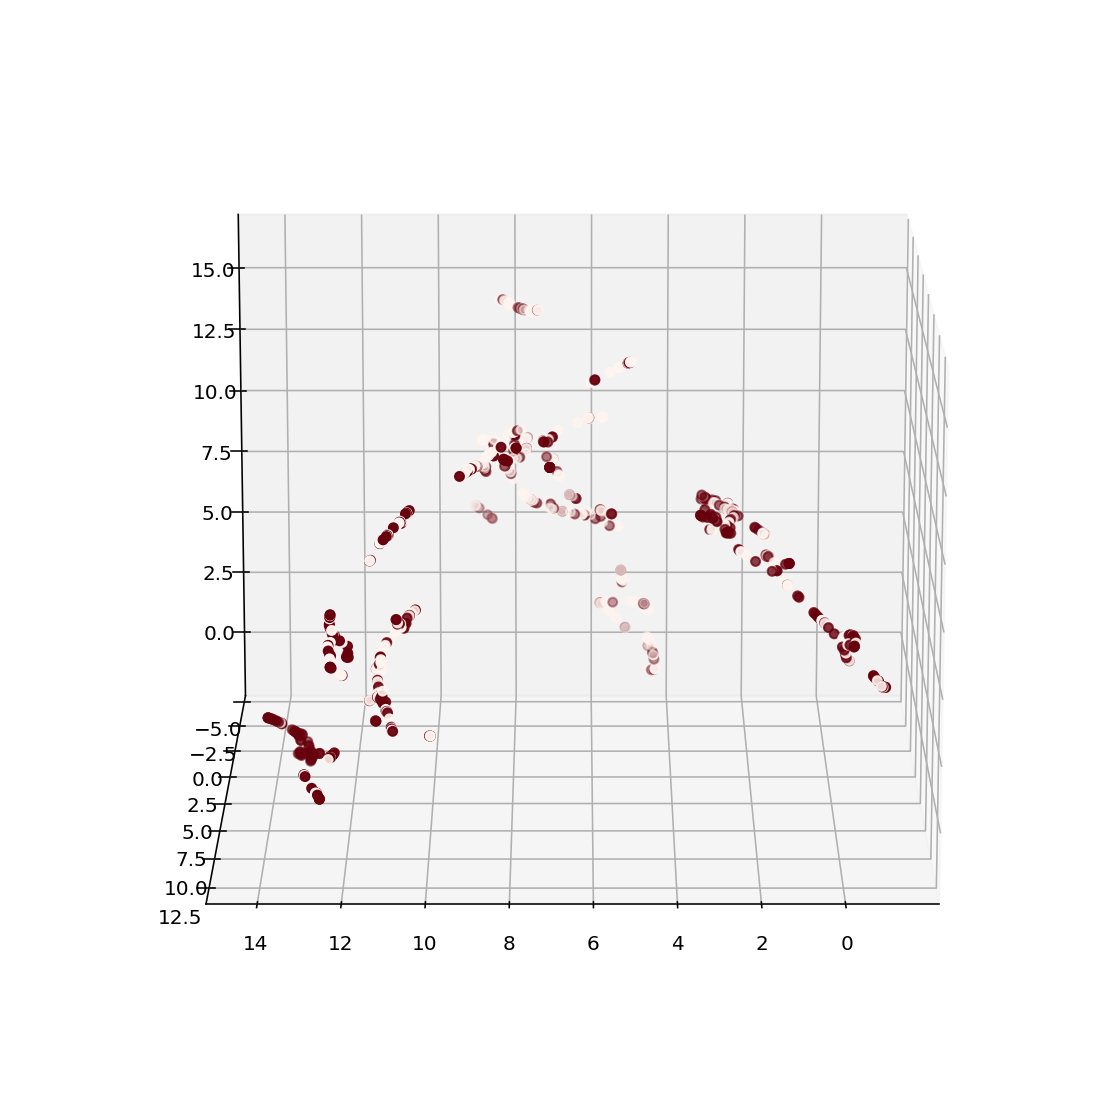

In [52]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = umap_features2[:, 0], umap_features2[:, 1], umap_features2[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
# rotate the axes and update
ax.view_init(15,90)
plt.show()

In [53]:
val_bins = [float(i) for i in range(3, 50, 3)]
val_bins = val_bins + [0.5, 2.0, 100.0, 200.0, 300.0, 1000.0]
def to_bin(x, bins):
    for val in bins:
        if x <= val:
            return val
X['val_bins'] = X['valuation'].apply(to_bin, args = (val_bins,))

In [54]:
X[numeric_cols]

,ask,equity,valuation
0,5.0,15.0,3.33333
1,46.0,10.0,46.00000
2,120.0,10.0,120.00000
3,25.0,25.0,10.00000
4,100.0,15.0,66.66667
...,...,...,...
890,35.0,10.0,35.00000
891,25.0,7.5,33.33333
892,50.0,5.0,100.00000
893,10.0,16.0,6.25000


In [55]:
X.ask.describe()

count    894.000000
mean      28.062304
std       40.081313
min        1.000000
25%       10.000000
50%       15.000000
75%       30.000000
max      500.000000
Name: ask, dtype: float64

In [56]:
ask_bins = [float(i) for i in range(7, 30, 2)]
ask_bins = ask_bins + [3.0, 50.0, 100.0, 500.0, 1000.0]
X['ask_bins'] = X['ask'].apply(to_bin, args = (ask_bins,))

In [57]:
X

,category,ask,equity,valuation,state,city,gender,val_bins,ask_bins
0,7,5.0,15.0,3.33333,11,7,0,6.0,7.0
1,5,46.0,10.0,46.00000,30,214,1,48.0,50.0
2,1,120.0,10.0,120.00000,27,33,1,200.0,500.0
3,8,25.0,25.0,10.00000,10,224,1,12.0,25.0
4,11,100.0,15.0,66.66667,23,220,1,100.0,100.0
...,...,...,...,...,...,...,...,...,...
890,8,35.0,10.0,35.00000,46,249,1,36.0,50.0
891,5,25.0,7.5,33.33333,46,249,1,36.0,25.0
892,3,50.0,5.0,100.00000,4,249,1,100.0,50.0
893,8,10.0,16.0,6.25000,46,249,1,9.0,11.0


In [58]:
equity_bins = [float(i) for i in range (1, 50, 10)]
equity_bins = equity_bins + [75.0, 100.0]
X['equity_bins'] = X['equity'].apply(to_bin, args = (equity_bins,))

In [59]:
cat_X = X[catcols + ['equity_bins', 'ask_bins', 'val_bins']]

In [60]:
cat_X

,category,state,city,gender,equity_bins,ask_bins,val_bins
0,7,11,7,0,21.0,7.0,6.0
1,5,30,214,1,11.0,50.0,48.0
2,1,27,33,1,11.0,500.0,200.0
3,8,10,224,1,31.0,25.0,12.0
4,11,23,220,1,21.0,100.0,100.0
...,...,...,...,...,...,...,...
890,8,46,249,1,11.0,50.0,36.0
891,5,46,249,1,11.0,25.0,36.0
892,3,4,249,1,11.0,50.0,100.0
893,8,46,249,1,21.0,11.0,9.0


In [61]:
# num_unique = pd.unique(cat_X.to_numpy().ravel('K')).shape[0] #unique over all cats
num_unique = 1 
for col in cat_X:
    num_unique += cat_X[col].nunique()
print(num_unique)

356


In [62]:
cat_X = cat_X.applymap(lambda x: int(x))

In [63]:
encoder = LabelEncoder()
cat_X['equity_bins'] = encoder.fit_transform(cat_X['equity_bins'])
encoder = LabelEncoder()
cat_X['ask_bins'] = encoder.fit_transform(cat_X['ask_bins'])
encoder = LabelEncoder()
cat_X['val_bins'] = encoder.fit_transform(cat_X['val_bins'])

In [64]:
cat_X

,category,state,city,gender,equity_bins,ask_bins,val_bins
0,7,11,7,0,1,0,1
1,5,30,214,1,0,12,15
2,1,27,33,1,0,14,17
3,8,10,224,1,2,9,3
4,11,23,220,1,1,13,16
...,...,...,...,...,...,...,...
890,8,46,249,1,0,12,11
891,5,46,249,1,0,9,11
892,3,4,249,1,0,12,16
893,8,46,249,1,1,2,2


In [65]:
def single_embedding_model(data, catcols):
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = 3 #int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        print(f"{c} has {num_unique_values}")
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
#     x = layers.DenseFeatures(feature_columns)
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(8, activation="relu", name = 'feature_vector')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs=[inputs], outputs=y)
    return model

In [66]:
model3 = single_embedding_model(cat_X, cat_X.columns.to_list())

category has 14
state has 47
city has 250
gender has 3
equity_bins has 6
ask_bins has 15
val_bins has 20


In [67]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [68]:
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['AUC', 'accuracy'])

In [69]:
es = callbacks.EarlyStopping(monitor ='val_loss', patience = 5, restore_best_weights = True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

In [70]:
categorical = [cat_X[col] for col in cat_X]

In [71]:
model3.fit(x = categorical, y = y, epochs = 30, callbacks = [es, rlr], validation_split = 0.2)

Epoch 1/30
23/23 [==============================] - 1s 63ms/step - loss: 1.0859 - auc_2: 0.4812 - accuracy: 0.4867 - val_loss: 0.6808 - val_auc_2: 0.6367 - val_accuracy: 0.6816
Epoch 2/30
23/23 [==============================] - 1s 60ms/step - loss: 0.9314 - auc_2: 0.5256 - accuracy: 0.5077 - val_loss: 0.6695 - val_auc_2: 0.6251 - val_accuracy: 0.6816
Epoch 3/30
23/23 [==============================] - 1s 58ms/step - loss: 0.8737 - auc_2: 0.5469 - accuracy: 0.5469 - val_loss: 0.6635 - val_auc_2: 0.6374 - val_accuracy: 0.6816
Epoch 4/30
23/23 [==============================] - 1s 59ms/step - loss: 0.8294 - auc_2: 0.5762 - accuracy: 0.5483 - val_loss: 0.6588 - val_auc_2: 0.6480 - val_accuracy: 0.6816
Epoch 5/30
23/23 [==============================] - 1s 62ms/step - loss: 0.8443 - auc_2: 0.5427 - accuracy: 0.5315 - val_loss: 0.6538 - val_auc_2: 0.6435 - val_accuracy: 0.6816
Epoch 6/30
23/23 [==============================] - 1s 59ms/step - loss: 0.8248 - auc_2: 0.5734 - accuracy: 0.5650 

In [72]:
cat_X.columns

Index(['category', 'state', 'city', 'gender', 'equity_bins', 'ask_bins',
       'val_bins'],
      dtype='object')

In [73]:
city_embedding3 = model3.get_layer('city')
state_embedding3 = model3.get_layer('state')
gender_embedding3 = model3.get_layer('gender')
cat_embedding3 = model3.get_layer('category')
all_cat_features3 = Model(model3.input, model3.get_layer('feature_vector').output)
city_embeddings3 = city_embedding3(tf.constant(cat_X['city']))
state_embeddings3 = state_embedding3(tf.constant(cat_X['state']))
gender_embeddings3 = gender_embedding3(tf.constant(cat_X['gender']))
cat_embeddings3 = cat_embedding3(tf.constant(cat_X['category']))
feature_embeddings3 = all_cat_features3.predict(categorical)

In [74]:
mapper3 = umap.UMAP(n_components = 3, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings3)
umap_features3 = mapper3.transform(feature_embeddings3)
pd.DataFrame(umap_features3).to_csv("umap3.csv", index = False)

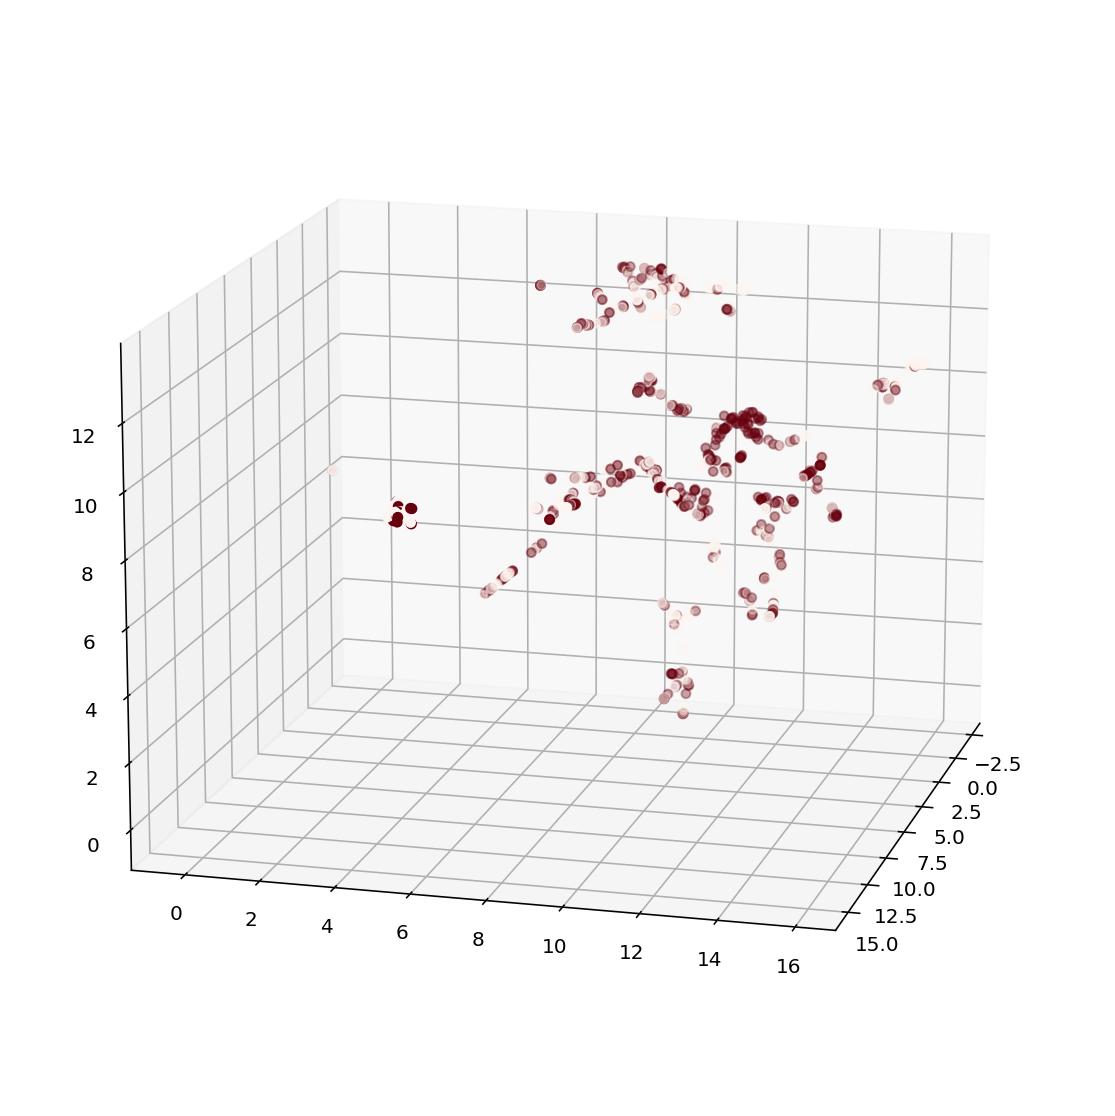

In [75]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
xs, ys, zs = umap_features3[:, 0], umap_features3[:, 1], umap_features3[:, 2]
colors = y
ax.scatter3D(xs, ys, zs, c = y.iloc[:, 0], cmap='Reds');
# rotate the axes and update
ax.view_init(15,15)
plt.show()

In [76]:
categorical

[0       7
 1       5
 2       1
 3       8
 4      11
        ..
 890     8
 891     5
 892     3
 893     8
 894    10
 Name: category, Length: 894, dtype: int64,
 0      11
 1      30
 2      27
 3      10
 4      23
        ..
 890    46
 891    46
 892     4
 893    46
 894    46
 Name: state, Length: 894, dtype: int64,
 0        7
 1      214
 2       33
 3      224
 4      220
       ... 
 890    249
 891    249
 892    249
 893    249
 894    249
 Name: city, Length: 894, dtype: int64,
 0      0
 1      1
 2      1
 3      1
 4      1
       ..
 890    1
 891    1
 892    1
 893    1
 894    2
 Name: gender, Length: 894, dtype: int64,
 0      1
 1      0
 2      0
 3      2
 4      1
       ..
 890    0
 891    0
 892    0
 893    1
 894    0
 Name: equity_bins, Length: 894, dtype: int64,
 0       0
 1      12
 2      14
 3       9
 4      13
        ..
 890    12
 891     9
 892    12
 893     2
 894     9
 Name: ask_bins, Length: 894, dtype: int64,
 0       1
 1      15
 2   

In [77]:
women = cat_X[cat_X.gender == 0]
w_labels = y[cat_X.gender == 0]
wcat = [women[col] for col in women]

men = cat_X[cat_X.gender == 1]
m_labels = y[cat_X.gender == 1]
mcat = [men[col] for col in men]

In [78]:
feature_embeddings_female = all_cat_features3.predict(wcat)
feature_embeddings_male = all_cat_features3.predict(mcat)

<AxesSubplot:>

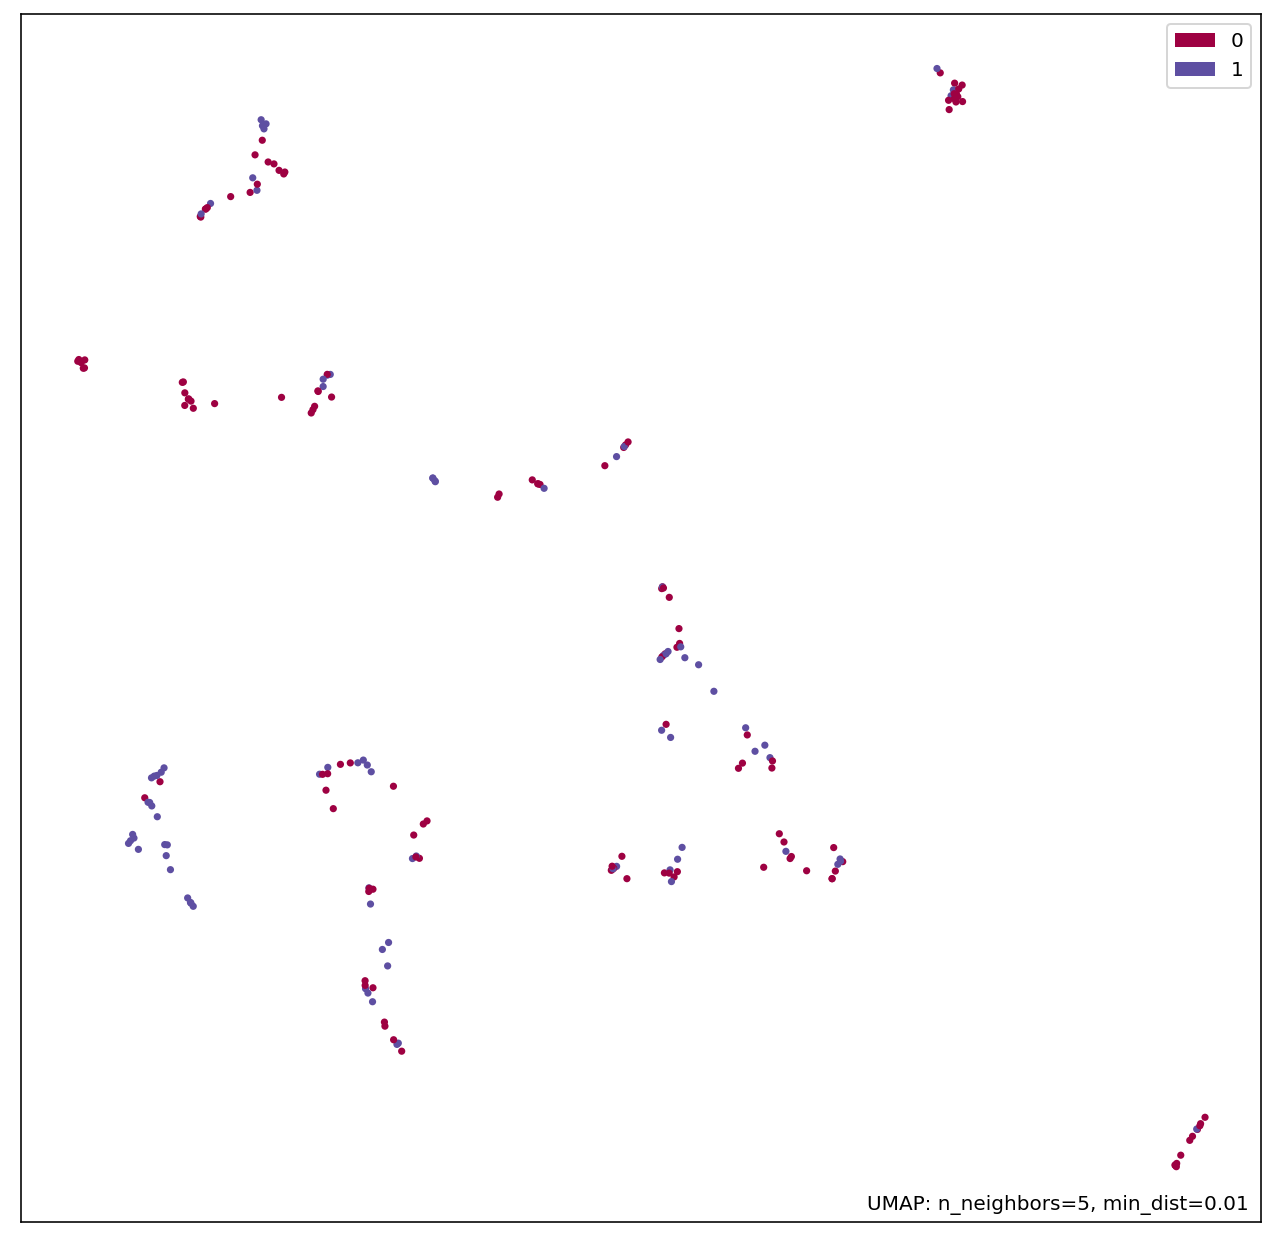

In [79]:
mapper2d = umap.UMAP(n_components = 2, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings_female)
umap_features2d = mapper2d.transform(feature_embeddings_female)
umap.plot.points(mapper2d, labels=w_labels.iloc[:, 0])

In [80]:
umap2 = pd.DataFrame(umap_features2d, columns = ['x', 'y'])
umap2['labels'] = y.iloc[:, 0]
umap2.to_csv("umap2dfeatures_w.csv", index = False)

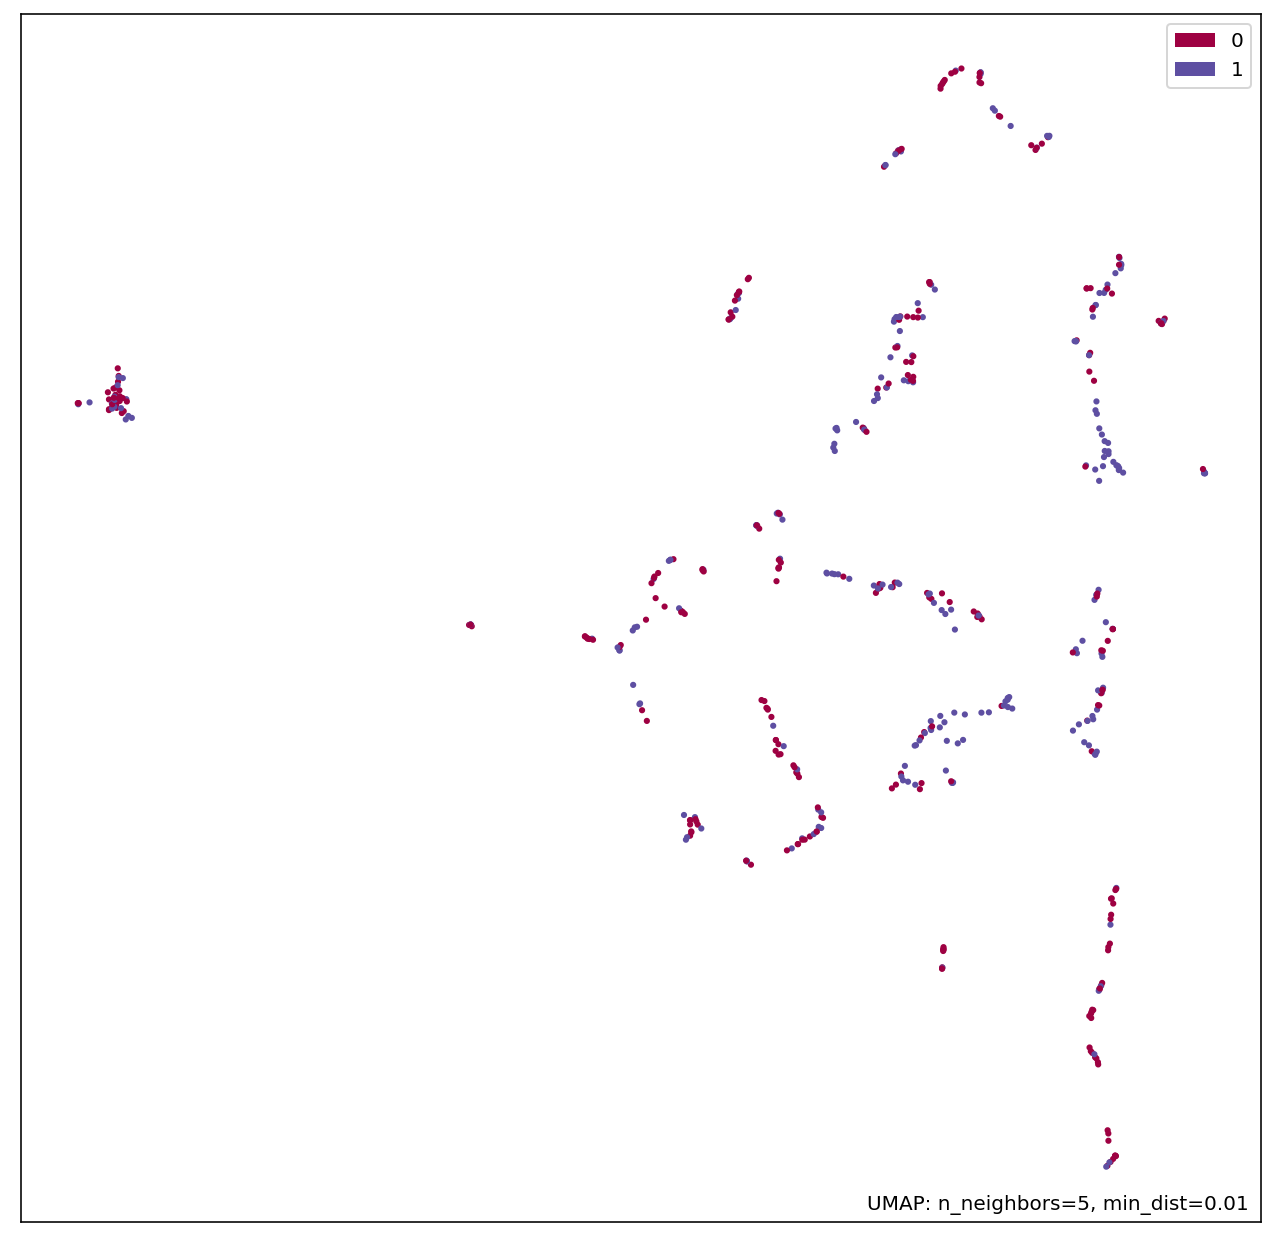

In [81]:
mapper2d = umap.UMAP(n_components = 2, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings_male)
umap_features2d = mapper2d.transform(feature_embeddings_male)
umap.plot.points(mapper2d, labels=m_labels.iloc[:, 0])
umap2 = pd.DataFrame(umap_features2d, columns = ['x', 'y'])
umap2['labels'] = y.iloc[:, 0]
umap2.to_csv("umap2dfeatures_m.csv", index = False)

In [82]:
cats = [cat_X[cat] for cat in cat_X]

In [83]:
feature_embeddings = all_cat_features3.predict(cats)

In [84]:
feature_embeddings.shape

(894, 8)

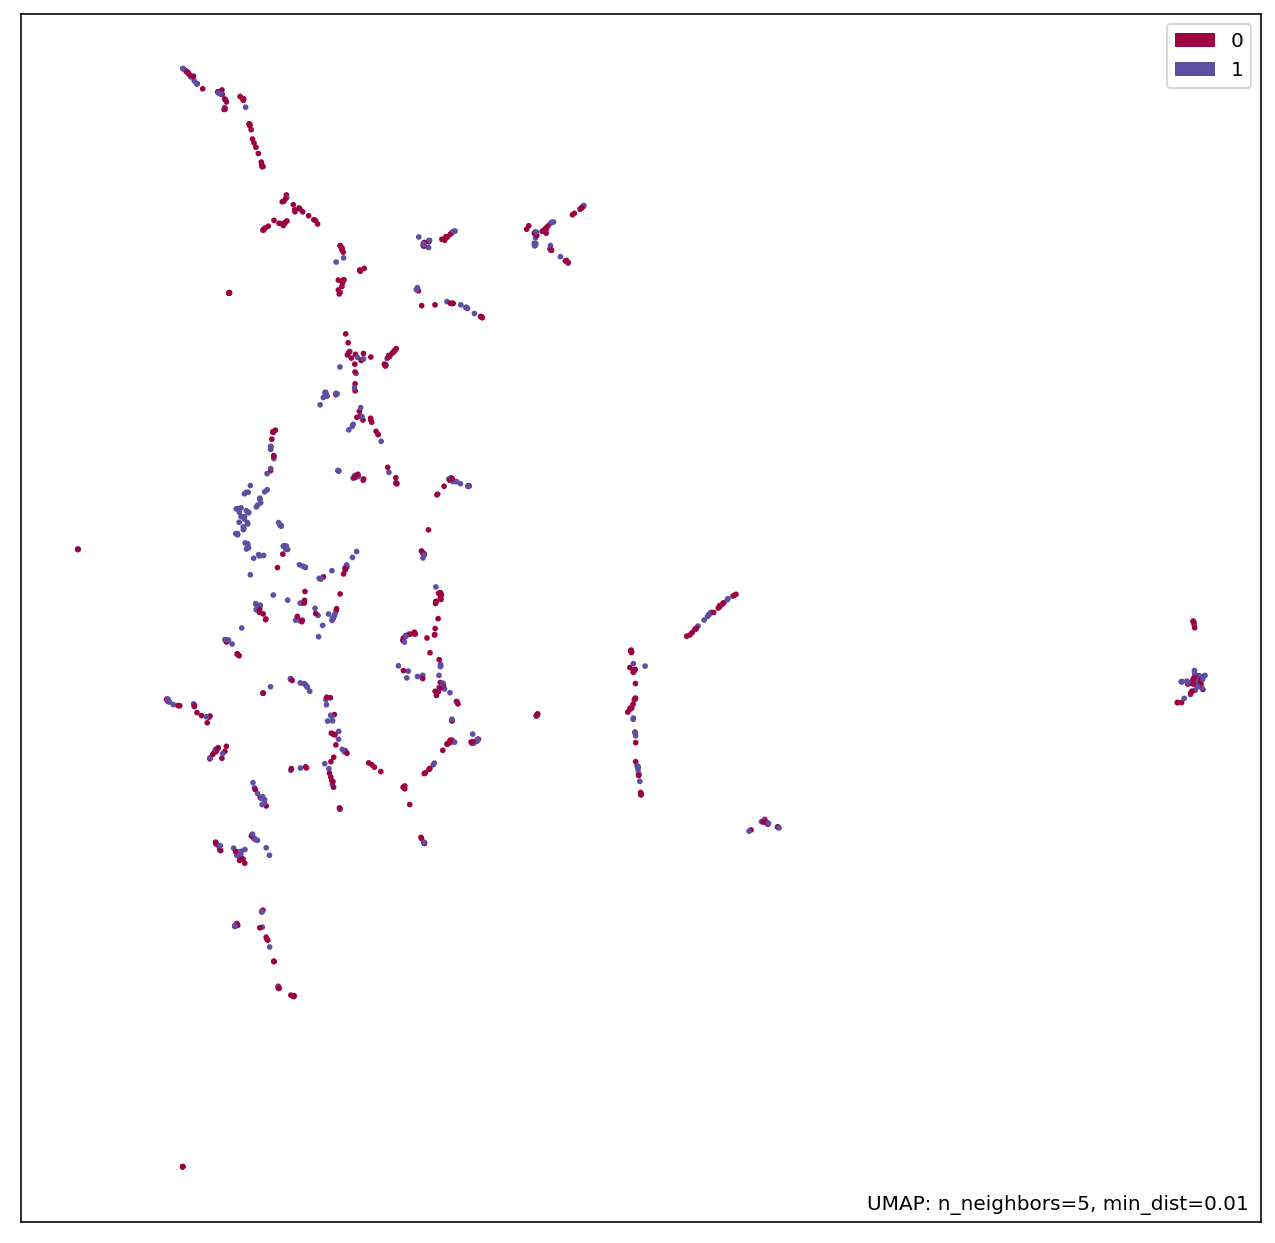

In [85]:
mapper2d = umap.UMAP(n_components = 2, min_dist = 0.01, n_neighbors = 5).fit(feature_embeddings)
umap_features2d = mapper2d.transform(feature_embeddings)
umap.plot.points(mapper2d, labels=y.iloc[:, 0])

umap2full = pd.DataFrame(umap_features2d, columns = ['x', 'y'])

In [86]:
umap2full['deal']= y.iloc[:, 0]
umap2full

,x,y,deal
0,1.004423,14.435899,0.0
1,2.463902,9.105005,0.0
2,-6.020214,9.178639,1.0
3,-0.115036,7.547134,1.0
4,2.877979,7.031739,1.0
...,...,...,...
889,0.399549,4.344561,1.0
890,1.999124,4.704468,0.0
891,21.332199,6.663058,0.0
892,21.349621,6.774209,0.0


In [87]:
umap2full[cat_X.columns] = cat_X

In [88]:
umap2full.to_csv("fullumap2filter.csv", index = False)

In [89]:
umapmini = umap2full[['x', 'y', 'deal', 'gender']]
umapmini.to_csv("umapmini.csv", index = False)